In [14]:
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor
    
np.random.seed(42)

# Convolutional neural networks

## Surname classification

We will learn to predict whether a word is a surname.

In [45]:
# Raw data
train_df = pd.read_csv(".data/imdb_train.tsv", delimiter="\t")
test_df = pd.read_csv(".data/imdb_test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


In [46]:
train_df.head()

,is_positive,review
0,0,"Dreamgirls, despite its fistful of Tony wins i..."
1,0,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...
3,0,Spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...


In [47]:
train_data, test_data, train_labels, test_labels = train_test_split(train_df['review'], train_df['is_positive'], test_size=0.33, random_state=42)

In [48]:
list(zip(train_data, train_labels))[::1500]

[("Another big star cast, another glamour's set, another reputed director, another flick filled with songs that's topping the chart buster, but alas what's missing at the day end is a story that every moviegoer expects of from such a big budget motion picture. So much hype is what that was lurking around the movie before it's' red carpet premiere. A hype which went to an extent where Anil Kapoor envisages that the movie would be one of the finest love stories ever made after Dilwale Dulhaniya Le Jayenge. Well Anilji, which movie were you speaking of? Well the plot of the movie is about 6 different couples and 12 different people, who have a total different stance towards life, but despite their different approach towards life they all have one common problem, that's LOVE. Well indeed a luring theme. But little did we expect that the movie would be such boredom that it will let down the last expectation the audience would have from such a multistarrer movie. These are kinda movies which

The data is also very balanced

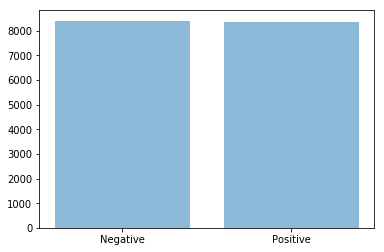

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

positive_count = np.sum(train_labels == 1)
negative_count = len(train_labels) - positive_count
 
plt.bar(np.arange(2), [negative_count, positive_count], align='center', alpha=0.5)
plt.xticks(np.arange(2), ('Negative', 'Positive'))
    
plt.show()

In [52]:
print('Accuracy = {:.2%}'.format((train_labels == 0).mean()))

Accuracy = 50.19%


However, it will be rather useless to always say that the word is not a surname. This, of course, is a question - what is worse, in vain to declare a word a last name (a mistake of the first kind) or not to find a last name.

<img src="https://effectsizefaq.files.wordpress.com/2010/05/type-i-and-type-ii-errors.jpg" style="border:none;width:35%">

We will measure precision, recall and their combination - $ F_1 $ -measure.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png" style="border:none;width:25%">

$$\text{precision} = \frac{tp}{tp + fp}.$$
$$\text{recall} = \frac{tp}{tp + fn}.$$
$$\text{F}_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}.$$

Let's start with a baseline on the regulars.

And now seriously - a baseline on logistic regression over N-gram characters.

**Assignment** Make a classification with the LogisticRegression model. Calculate the F1-measure.

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer()
classifier = LogisticRegression(solver='lbfgs')

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

/Users/newscred/.local/share/virtualenvs/NeuralNetwork-Db90wnYD/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [55]:
test_preds = model.predict(test_df['review'])
print('F1-score = {:.2%}'.format(f1_score(test_df['is_positive'], test_preds)))

# from sklearn.metrics import accuracy_score
# preds = model.predict(test_data)
# print('Test accuracy = {:.2%}'.format(accuracy_score(test_labels, preds)))

F1-score = 86.21%


Look at the predictions

In [56]:
import eli5

eli5.show_weights(model, vec=vectorizer, top=40)

Weight?,Feature
+1.699,wonderfully
+1.688,refreshing
+1.669,funniest
+1.594,rare
+1.569,surprisingly
+1.537,superb
+1.366,incredible
+1.297,enjoyable
+1.278,subtle
+1.265,gem


In [57]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In addition to the blunt counting of the F1-score, you can look at precision-recall curves. First, they are beautiful. Secondly, it is clear from them that you can improve the quality (F1-score) by selecting another threshold - ** although it is impossible to do this on the test **.

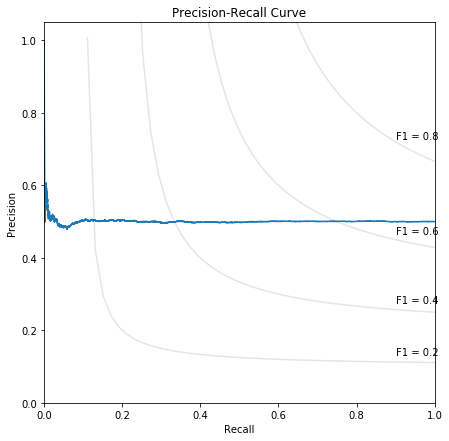

In [58]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(test_df['is_positive'], model.predict_proba(train_df['review'])[:, 1])

plt.figure(figsize=(7, 7))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('F1 = {0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

plt.plot(recall, precision)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.show()

**Task** Come up with signs to improve the quality of the model.

## Character-Level Convolutions

### General description of convolutions

Let me remind you that convolutions are what started the HYIP of neural networks in the area of ​​the 2012th.

They work like this:
<img src="https://image.ibb.co/e6t8ZK/Convolution.gif" width="50%">

From [Feature extraction using convolution](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution).

Formally - filter sets are learned, each of which is scalar multiplied by elements of the matrix of attributes. In the picture above, the original matrix collapses with the filter.
$$
 \begin{pmatrix}
  1 & 0 & 1 \\
  0 & 1 & 0 \\
  1 & 0 & 1
 \end{pmatrix}
$$

But we must not forget that convolutions usually have another dimension, such as the number of channels. For example, pictures usually have three channels: RGB.
It clearly demonstrates how filters look like [here] (http://cs231n.github.io/convolutional-networks/#conv).

After convolutions, pooling layers usually follow. They help reduce the dimension of the tensor with which to work. The most common is max-pooling:

<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" width="50%">

### Text wrappers

For convolution texts, they work as n-gram detectors (approximately). A canonical example of a symbolic convolution network:

<img src="https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png" width="50%">

From [Character-Aware Neural Language Models](https://arxiv.org/abs/1508.06615)

* How many filters does the example use? *

The picture shows how 2, 3, and 4 grams are extracted from a word. For example, yellow is trigrams. A yellow filter is applied to all trigrams in a word, and then the strongest signal is extracted using global max-pooling.

What does this mean, if specifically?

Each character is displayed using embeddings in some vector. And their sequences are in the concatenation of embeddings.

For example, "abs" $ \ to [v_a; v_b; v_s] \in \mathbb {R} ^ {3 d} $, where $ d $ is the embedding dimension. The yellow filter $ f_k $ has the same dimension $ 3d $.

Its attachment is the scalar product $ \left ([v_a; v_b; v_s] \odot f_k \right) \in \mathbb R $ (one of the yellow squares in the feature map for this filter).

Max-pooling selects $ max_i \left ([v_ {i-1}; v_ {i}; v_ {i + 1}] \odot f_k \right) $, where $ i $ runs over all indexes of the word from 1 to $ | w | - $ 1 (or over a larger range, if there are paddings).
This maximum corresponds to the trigram that is closest to the filter over the cosine distance.

As a result, after max-pooling, the vector encodes information about which of the n-grams met in the word: if a trigram close to our $ f_k $ met, then the vector will have a great value in the $ k $ position of the vector, otherwise small

And we just learn the filters. That is, the network must learn to determine which of the n-grams are significant and which are not.

### Toy example

Let's look at an example of what is happening there. Take the word:

In [34]:
word = 'Hello Word'

In [35]:
char2index = {symb: ind for ind, symb in enumerate(set(word))}

char2index

{'W': 0, 'd': 1, 'H': 2, ' ': 3, 'e': 4, 'o': 5, 'l': 6, 'r': 7}

Each character is associated with embedding. The easiest way to do embeddingings is to take a single matrix. When we had tens of thousands of words, such embeddings were not very good, but now only a few characters are quite adequate to assign them orthogonal vectors of small dimension.

In [36]:
embeddings = torch.eye(len(char2index))

embeddings

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]])

Construct the tensor of the indexes of the characters of the word:

In [37]:
word_tensor = torch.LongTensor([char2index[symb] for symb in word])

word_tensor

tensor([2, 4, 6, 6, 5, 3, 0, 5, 7, 1])

Let's display it in embeddings. Got the same rectangle as in the picture (transposition is necessary to look in the same direction).

In [40]:
word_embs = embeddings[word_tensor].t()

word_embs

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

Now it came to convolutions. Let's make the filter-detector of the trigram `new`:

In [43]:
kernel_name = 'Hel'

kernel_indices = torch.LongTensor([char2index[symb] for symb in kernel_name])
kernel_weights = embeddings[kernel_indices].t()

kernel_weights

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 0., 0.]])

To calculate the convolution, use the function:
```python
F.conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1) -> Tensor
```

input: input tensor of shape ($N \times C_{in} \times H_{in} \times W_{in}$)  
weight: filters of shape ($C_{out} \times C_{in} \times H_{out} \times W_{out}$)

$ N $ - the size of the batch (1 for us). $ C_ {in} $ - the number of channels. In our case, it will always be 1 (for now). $ C_ {out} $ - the number of filters. It is still 1.

We will need four-dimensional tensors, for this we use `view`:

In [0]:
word_embs = word_embs.view(1, 1, word_embs.shape[0], word_embs.shape[1])
kernel_weights = kernel_weights.view(1, 1, kernel_weights.shape[0], kernel_weights.shape[1])

conv_result = F.conv2d(word_embs, kernel_weights)[0, 0]

print('Conv =', conv_result)
print('Max pooling =', conv_result.max())

Свертка сказала, что данный фильтр есть на последней позиции. Пулинг сказал, пофиг на какой позиции - главное, он есть.

### Подготовка данных

Первый шаг - определить, какой длины слова у нас. Ограничимся каким-то числом, а более длинные будем обрезать.

In [0]:
from collections import Counter 
    
def find_max_len(counter, threshold):
    sum_count = sum(counter.values())
    cum_count = 0
    for i in range(max(counter)):
        cum_count += counter[i]
        if cum_count > sum_count * threshold:
            return i
    return max(counter)

word_len_counter = Counter()
for word in train_data:
    word_len_counter[len(word)] += 1
    
threshold = 0.99
MAX_WORD_LEN = find_max_len(word_len_counter, threshold)

print('Max word length for {:.0%} of words is {}'.format(threshold, MAX_WORD_LEN))

Соберем отображение из символов в индексы.

In [0]:
chars = set()
for word in train_data:
    chars.update(word)

char_index = {c : i + 1 for i, c in enumerate(chars)}
char_index['<pad>'] = 0
    
print(char_index)

**Задание** Сконвертируйте данные

In [0]:
def convert_data(data, max_word_len, char_index):
    return <np array>

X_train = convert_data(train_data, MAX_WORD_LEN, char_index)
X_test = convert_data(test_data, MAX_WORD_LEN, char_index)

In [0]:
def iterate_batches(X, y, batch_size):
    num_samples = X.shape[0]

    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        
        batch_idx = indices[start: end]
        
        yield X[batch_idx], y[batch_idx]

### ConvCharNN

Now we build a convolutional model.

Let it build trigrams - that is, apply filters for 3 characters.

Let's start with the sequence: `nn.Embedding -> nn.Conv2d -> nn.ReLU -> max pooling -> nn.Linear`

`nn.Conv2d` is the layer containing the creation and initialization of filters, and calling` F.conv2d` to them and the input.

* Life hacking: * sequences of operations can be packed in `nn.Sequential`.

In [0]:
class ConvClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, filters_count):
        super().__init__()
        
        self._embedding = ...
        self._dropout = nn.Dropout(0.2)
        self._conv3 = ...
        self._out_layer = ...
        
    def forward(self, inputs):
        '''
        inputs - LongTensor with shape (batch_size, max_word_len)
        outputs - FloatTensor with shape (batch_size,)
        '''
        
        outputs = self.embed(inputs)
        return self._out_layer(outputs).squeeze(-1)
    
    def embed(self, inputs):
        <calc word embedding>

Проверьте, что всё работает:

In [0]:
X_batch, y_batch = next(iterate_batches(X_train, train_labels, 32))
X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

model = ConvClassifier(len(char_index) + 1, 24, 64)
logits = model(X_batch)

**Задание** Подсчитайте precision, recall и F1-score для полученных предсказаний.

In [0]:
<calc precision, recall, f1-score>

**Задание** Напишем теперь цикл обучения, который не слишком сложно будет переиспользовать

In [0]:
import math
import time

def do_epoch(model, criterion, data, batch_size, optimizer=None):
    epoch_loss, epoch_tp, epoch_fp, epoch_fn = 0, 0, 0, 0
    
    is_train = not optimizer is None
    model.train(is_train)
    
    data, labels = data
    batchs_count = math.ceil(data.shape[0] / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        for i, (X_batch, y_batch) in enumerate(iterate_batches(data, labels, batch_size)):
            X_batch, y_batch = LongTensor(X_batch), FloatTensor(y_batch)

            logits = <calc logits>

            loss = <calc loss>
            epoch_loss += loss.item()

            if is_train:
                <how to optimize the beast?>

            <u can move the stuff to some function>
            tp = <calc true positives>
            fp = <calc false positives>
            fn = <calc false negatives>

            precision = ...
            recall = ...
            f1 = ...
            
            epoch_tp += tp
            epoch_fp += fp
            epoch_fn += fn

            print('\r[{} / {}]: Loss = {:.4f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'.format(
                  i, batchs_count, loss.item(), precision, recall, f1), end='')
        
    precision = ...
    recall = ...
    f1 = ...
        
    return epoch_loss / batchs_count, recall, precision, f1

def fit(model, criterion, optimizer, train_data, epochs_count=1, 
        batch_size=32, val_data=None, val_batch_size=None):
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        start_time = time.time()
        train_loss, train_recall, train_precision, train_f1 = do_epoch(
            model, criterion, train_data, batch_size, optimizer
        )
        
        output_info = '\rEpoch {} / {}, Epoch Time = {:.2f}s: Train Loss = {:.4f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'
        if not val_data is None:
            val_loss, val_recall, val_precision, val_f1 = do_epoch(model, criterion, val_data, val_batch_size, None)
            
            epoch_time = time.time() - start_time
            output_info += ', Val Loss = {:.4f}, Precision = {:.2%}, Recall = {:.2%}, F1 = {:.2%}'
            print(output_info.format(epoch+1, epochs_count, epoch_time, 
                                     train_loss, train_recall, train_precision, train_f1,
                                     val_loss, val_recall, val_precision, val_f1))
        else:
            epoch_time = time.time() - start_time
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss))

In [0]:
model = ConvClassifier(len(char_index) + 1, 24, 128).cuda()

criterion = nn.BCEWithLogitsLoss().cuda()

optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad])

fit(model, criterion, optimizer, train_data=(X_train, train_labels), epochs_count=200, 
    batch_size=512, val_data=(X_test, test_labels), val_batch_size=1024)

**Задание** Проверьте работу классификатора на вашей фамилии.

Нужно не забыть перевести модель в режим инференса - некоторые слои на трейне и инференсе ведут себя по-разному.

In [0]:
model.eval()

surname = "..."
surname_tensor = ...
print('P({} is surname) = {}'.format(surname, torch.sigmoid(model(surname_tensor))))

**Задание** Постройте precision-recall curve для данного классификатора и предыдущей модели

## Визуализации

### Визуализация эмбеддингов

**Задание** Визуализируем эмбеддинги слов, как это делали раньше

In [0]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=100)
    return scale(tsne.fit_transform(word_vectors))
    
    
def visualize_embeddings(embeddings, token, colors):
    tsne = get_tsne_projection(embeddings)
    draw_vectors(tsne[:, 0], tsne[:, 1], color=colors, token=token)

In [0]:
word_indices = np.random.choice(np.arange(len(test_data)), 1000, replace=False)
words = [test_data[ind] for ind in word_indices]
labels = test_labels[word_indices]

word_tensor = convert_data(words, max(len(x) for x in words), char_index)
embeddings = <calc embeddings>

colors = ['red' if label else 'blue' for label in labels]

visualize_embeddings(embeddings, words, colors)

### Visualization of the received bundles

Among other things, we have a logistic regression from above. You can visualize it as in eli5.

** Assignment ** Achieve this.

In [0]:
model.eval()

word = 'Смирнов'

Посчитайте вероятность, что слово - фамилия.

In [0]:
inputs = word -> LongTensor
prob = torch.sigmoid(model(inputs)).item()

Посчитайте результат свертки и пулинга

In [0]:
convs = ...
maxs, positions = convs.squeeze().max(-1)

Домножьте выход пулинга на веса выходного слоя

In [0]:
linear_weights = ...

Посчитайте веса символов: каждый фильтр прикладывается к какой-то позиции - прибавим его вес к накрываемым символам.

In [0]:
symb_weights = ...

Визуализируем это:

In [0]:
from IPython.core.display import HTML

def get_color_hex(weight):
    cmap = plt.get_cmap("RdYlGn")
    rgba = cmap(weight, bytes=True)
    return '#%02X%02X%02X' % rgba[:3]

symb_template = '<span style="background-color: {color_hex}">{symb}</span>'
res = '<p>P(surname) = {:.2%}</p>'.format(prob)
for symb, weight in zip(word, symb_weights):
    res += symb_template.format(color_hex=get_color_hex(weight), symb=symb)
res = '<p>' + res + '</p>'

HTML(res)

Объединим все в функции:

In [0]:
def calc_weights(word):
    <calc>
    
    return prob, symb_weights

def visualize(word):
    prob, symb_weights = calc_weights(word)
    
    symb_template = '<span style="background-color: {color_hex}">{symb}</span>'
    res = '<p>P(surname) = {:.2%}</p>'.format(prob)
    for symb, weight in zip(word, symb_weights):
        res += symb_template.format(color_hex=get_color_hex(weight), symb=symb)
    res = '<p>' + res + '</p>'
    return HTML(res)


visualize('Королев')

## Model improvement


**Task** To improve the stability of the model, it is worth adding the dropout `nn.Dropout` - a way to nullify a part of the scales at each epoch to regularize the model. Try adding it after embeddings and after convolution (or else somewhere else).

<img src="https://cdn-images-1.medium.com/max/1044/1*iWQzxhVlvadk6VAJjsgXgg.png" width="50%">

**Task** Another way to regularize a model is to use BatchNormalization (`nn.BatchNorm2d`). Try adding it after convolution.

**Task** Another way to improve the model is to add a bundle. Implement the model as in the picture at the beginning of the laptop: with convolutions of 2, 3, 4 characters.

**Assignment** Distinguish between Narrow and Wide convolutions - in fact, whether zero padding is added or not. For texts, this difference looks like this:<img src="https://image.ibb.co/eqGZaS/2018_03_28_11_23_17.png" width="50%">

*From Neural Network Methods in Natural Language Processing.*

On the left, there is no padding, on the right, there is. Try adding padding and see what happens. Potentially, it will help to learn good word prefixes.

# Referrence
[Convolutional Neural Networks, cs231n](http://cs231n.github.io/convolutional-networks/)  
[Understanding Convolutions, Christopher Olah](http://colah.github.io/posts/2014-07-Understanding-Convolutions/)  
[Understanding Convolutional Neural Networks for NLP, Denny Britz](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/)

[Character-Aware Neural Language Models, Yoon Kim et al, 2015](https://arxiv.org/abs/1508.06615)  
[Character-level Convolutional Networks for Text Classification, Zhang et al., 2015](https://arxiv.org/abs/1509.01626)  
[A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification Zhang et al., 2015](https://arxiv.org/abs/1510.03820)
[Learning Character-level Representations for Part-of-Speech Tagging, dos Santos et al, 2014](http://proceedings.mlr.press/v32/santos14.pdf)

[cs224n "Lecture 13: Convolutional Neural Networks"](https://www.youtube.com/watch?v=Lg6MZw_OOLI)